# Finding Similar Songs on Spotify - Part 3 - Siamese Networks with Tag Similarity

In this tutorial I will demonstrate how to apply machine learning to search for similar songs on Spotify.


## Tutorial Overview

1. Loading data
2. Preprocess data
3. Define Model
4. Fit Model
5. Evaluate Model



## Requiremnts

Install the following dependencies to run this tutorial:

In [1]:
%load_ext autoreload

%autoreload 2

# visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

# numeric and scientific processing
import numpy as np
import pandas as pd

# misc
import os
import progressbar

import tutorial_functions as tut_func

**Spotipy**

Spotipy is a thin client library for the Spotify Web API.

https://github.com/plamere/spotipy

In [2]:
import spotipy
import spotipy.util as util

TODO: describe how to get client credentials

In [3]:
os.environ["SPOTIPY_CLIENT_ID"]     = "8a7fffc37b6c44e6b7bc344c3295034c"
os.environ["SPOTIPY_CLIENT_SECRET"] = "f19dd914ba58408c9407dd6479b23812"

If you get the following message:

    User authentication requires interaction with your
    web browser. Once you enter your credentials and
    give authorization, you will be redirected to
    a url.  Paste that url you were directed to to
    complete the authorization.

    Opened https://accounts.spotify.com/authorize?scope=playlist-modify-public&redirect_uri=ht...
    

You need to authenticate your browser session. Follow the link and log in to Spotify. After login, you will be redirected to http://localhost/?code=... Copy the entire URL and paste it to the prompted textbox.

In [4]:
token = util.prompt_for_user_token("slychief", 
                                   "playlist-modify-public", 
                                   redirect_uri="http://localhost/")

sp = spotipy.Spotify(auth=token)

# Loading Data

Before we can train our models we first have to get some data.

## Download Echonest Features from Spotify

We use spotipy to access the Spotify API and to download metadata and audio features of Spotify tracks. The following list provides a selection of Spotify playlists of various music genres.

In [5]:
playlists = [
    
     {"name": "clubbeats",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DXbX3zSzB4MO0"},
     {"name": "softpop",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DWTwnEm1IYyoj"},
     {"name": "electropop",   "uri": "spotify:user:spotify:playlist:37i9dQZF1DX4uPi2roRUwU"},
     {"name": "rockclassics", "uri": "spotify:user:spotify:playlist:37i9dQZF1DWXRqgorJj26U"},
     {"name": "rockhymns",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DX4vth7idTQch"},
     {"name": "soft_rock",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DX6xOPeSOGone"},
     {"name": "metalcore",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DWXIcbzpLauPS"}, 
     {"name": "metal",        "uri": "spotify:user:spotify:playlist:37i9dQZF1DWWOaP4H0w5b0"},
     {"name": "classic_metal","uri": "spotify:user:spotify:playlist:37i9dQZF1DX2LTcinqsO68"},
     {"name": "grunge",       "uri": "spotify:user:spotify:playlist:37i9dQZF1DX11ghcIxjcjE"},
     {"name": "hiphop",       "uri": "spotify:user:spotify:playlist:37i9dQZF1DWVdgXTbYm2r0"},
     {"name": "poppunk",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DXa9wYJr1oMFq"},
     {"name": "classic",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DXcN1fAVSf7CR"}
    
]

### Caching with joblib

We will use caching to locally store retrieved data. This is on the one hand a requirement of the API and on the other it speeds up processing when we reload the notebook. *joblib* is a convenient library which simplifies caching.

*Update the cachdir to an appropriate path in the following cell*

In [6]:
from joblib import Memory

memory = Memory(cachedir='/home/schindler/tmp/spotify/', verbose=0)

In [7]:
@memory.cache
def get_spotify_data(track_id):
    
    # meta-data
    track_metadata      = sp.track(track_id)
    album_metadata      = sp.album(track_metadata["album"]["id"])
    artist_metadata     = sp.artist(track_metadata["artists"][0]["id"])
    
    # feature-data
    sequential_features = sp.audio_analysis(track_id)
    trackbased_features = sp.audio_features([track_id])
    
    return track_metadata, album_metadata, artist_metadata, sequential_features, trackbased_features

In [8]:
# Get Playlist meta-data
playlists = tut_func.get_playlist_metadata(sp, playlists)

# Get track-ids of all playlist entries
playlists = tut_func.get_track_ids(sp, playlists)

num_tracks_total = np.sum([playlist["num_tracks"] for playlist in playlists])

# Fetch data and features from Spotify
pbar = progressbar.ProgressBar(max_value=num_tracks_total)
pbar.start()

raw_track_data      = []
processed_track_ids = []

for playlist in playlists:

    for track_id in playlist["track_ids"]:

        try:
            # avoid duplicates in the data-set
            if track_id not in processed_track_ids:

                # retrieve data from Spotify
                spotify_data = get_spotify_data(track_id)

                raw_track_data.append([playlist["name"], spotify_data])
                processed_track_ids.append(track_id)

        except Exception as e:
            print e

        pbar.update(len(raw_track_data))

 97% (938 of 963) |#################################################################################################################################################################################     | Elapsed Time: 0:00:39 ETA: 0:00:01

# Aggregate data

Currently we only have a list of raw data-objects retrieved from the Spotify API. We need to transform this information to a more structured format.

In [9]:
# Aggregate Meta-data
metadata = tut_func.aggregate_metadata(raw_track_data)

# Aggregate Feature-data
feature_data = tut_func.aggregate_featuredata(raw_track_data, metadata)

# standardize sequential_features
feature_data -= feature_data.mean(axis=0)
feature_data /= feature_data.std(axis=0)

# Tag Similarities

In [10]:
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

In [11]:
mlb = MultiLabelBinarizer()
mlb = mlb.fit(metadata.genres)

genres_bin = pd.DataFrame(mlb.transform(metadata.genres), columns=mlb.classes_)

In [12]:
# align metadata with filtered tracks
metadata_aligned = metadata
metadata_aligned["featurespace_index"] = metadata.index.values
metadata_aligned = metadata_aligned.iloc[genres_bin.index]
metadata_aligned = metadata_aligned.reset_index()

In [13]:
# filter tracks without genre tags
genres_bin = genres_bin[genres_bin.sum(axis=1) > 0]

metadata_aligned = metadata_aligned.loc[genres_bin.index]

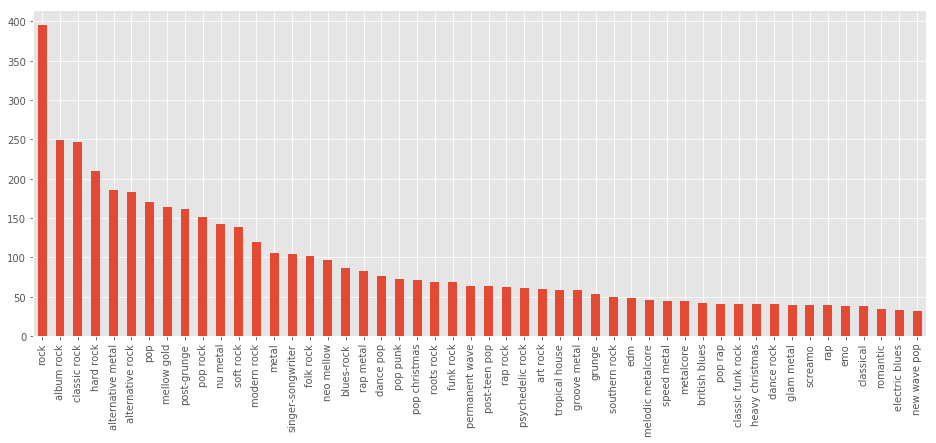

In [14]:
genres_bin.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar", figsize=(16,6));

In [15]:
tf  = genres_bin.sum(axis=0)
idf = np.log(genres_bin.shape[0] / tf)
genres_tf_idf = genres_bin / idf

In [16]:
genres_coocurrences = genres_bin.T.dot(genres_bin)

In [17]:
genres_coocurrences.iloc[:10,:10]

,acoustic pop,adult standards,album rock,alternative emo,alternative hip hop,alternative metal,alternative pop,alternative rock,anthem emo,anti-folk
acoustic pop,14,0,0,0,0,0,0,0,0,0
adult standards,0,13,13,0,0,0,0,0,0,0
album rock,0,13,249,0,0,21,0,48,0,0
alternative emo,0,0,0,1,0,0,0,0,1,0
alternative hip hop,0,0,0,0,1,0,0,0,0,0
alternative metal,0,0,21,0,0,185,0,113,0,0
alternative pop,0,0,0,0,0,0,3,3,0,1
alternative rock,0,0,48,0,0,113,3,183,0,1
anthem emo,0,0,0,1,0,0,0,0,1,0
anti-folk,0,0,0,0,0,0,1,1,0,1


In [18]:
from scipy.spatial.distance import dice, pdist, squareform

In [19]:
dists = pdist(genres_tf_idf, 'dice')

In [20]:
sims = pd.DataFrame(1 - squareform(dists))

In [21]:
sims.index = genres_tf_idf.index
sims.columns = genres_tf_idf.index

In [22]:
i = 381
idx = sims[i].sort_values(ascending=False).index

print metadata_aligned.iloc[i]

result = metadata.loc[idx]
result["sim"] = sims.loc[i,idx].values
result = result[["featurespace_index", "artist_name", "title", "year", "popularity", "genres", "playlist", "sim"]]
result[(result.sim > 0) & (result.index != i)][:10]
#result[(result.sim < 0.00001)]

index                                                               407
track_id                                         1O5qBgWDXf19N75X7Bvilv
artist_name                                                 The Subways
title                                                 Rock & Roll Queen
album_name                                           Young For Eternity
label                                                             WM UK
duration                                                         169946
popularity                                                           59
year                                                               2005
genres                [dance-punk, garage rock, indie rock, modern r...
playlist                                                      rockhymns
featurespace_index                                                  407
Name: 407, dtype: object


,featurespace_index,artist_name,title,year,popularity,genres,playlist,sim
379,379,Lynyrd Skynyrd,Free Bird,1973,70,"[album rock, blues-rock, classic rock, country...",rockclassics,1.000000
374,374,Lynyrd Skynyrd,Simple Man,1973,65,"[album rock, blues-rock, classic rock, country...",rockclassics,1.000000
339,339,Lynyrd Skynyrd,Gimme Three Steps,1973,57,"[album rock, blues-rock, classic rock, country...",rockclassics,1.000000
283,283,Boston,More Than a Feeling,1976,24,"[album rock, blues-rock, classic rock, hard ro...",rockclassics,0.888889
297,297,Boston,Peace of Mind,1976,18,"[album rock, blues-rock, classic rock, hard ro...",rockclassics,0.888889
340,340,Boston,Foreplay / Long Time,1976,15,"[album rock, blues-rock, classic rock, hard ro...",rockclassics,0.888889
493,493,Dire Straits,Your Latest Trick,1985,62,"[album rock, blues-rock, classic rock, hard ro...",soft_rock,0.823529
289,289,Dire Straits,Sultans Of Swing,1978,67,"[album rock, blues-rock, classic rock, hard ro...",rockclassics,0.823529
278,278,Bob Seger,Turn The Page - Live In Detroit/1975,1976,56,"[album rock, blues-rock, classic rock, country...",rockclassics,0.782609
290,290,Bob Seger,Old Time Rock & Roll,1978,61,"[album rock, blues-rock, classic rock, country...",rockclassics,0.782609


# Calculate Similarities

In [23]:
def create_pairs(feature_data, metadata, num_pairs_per_track):
    
    data_pairs = []
    labels     = []
    
    pbar = progressbar.ProgressBar(max_value=metadata_aligned.shape[0])
    pbar.start()
    
    i = 0
    
    for row_id, q_track in metadata_aligned.sample(frac=1).iterrows():
                
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata_aligned[metadata_aligned.playlist == q_track.playlist].sample(1)
            neg_example = metadata_aligned[metadata_aligned.playlist != q_track.playlist].sample(1)

            # create feature pairs
            data_pairs.append([feature_data[[metadata_aligned.loc[row_id].featurespace_index]][0], feature_data[[pos_example.featurespace_index]][0]])
            labels.append(sims.loc[row_id, pos_example.index].values[0])
            
            data_pairs.append([feature_data[[metadata_aligned.loc[row_id].featurespace_index]][0], feature_data[[neg_example.featurespace_index]][0]])
            labels.append(sims.loc[row_id, neg_example.index].values[0])
            
        pbar.update(i)
        
        i += 1

    return np.array(data_pairs), np.array(labels)

In [24]:
data_pairs, labels = create_pairs(feature_data, metadata, 10)

data_pairs.shape

 99% (889 of 892) |##################################################################################################################################################################################### | Elapsed Time: 0:00:20 ETA: 0:00:00

(17840, 2, 69)

In [25]:
from keras.layers import Input, Lambda
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.optimizers import Nadam, SGD
from keras.regularizers import l2, l1
from keras import backend as K
from keras.layers.merge import concatenate

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)


In [26]:
def create_siamese_network(input_dim):

    input_left  = Input(shape=input_dim)
    input_right = Input(shape=input_dim)

    layers_left  = Dense(100, activation="selu")(input_left)
    layers_left  = Dense(100, activation="selu")(layers_left)
    layers_left  = Dense(100, activation="selu")(layers_left)
    layers_right = Dense(100, activation="selu")(input_right)
    layers_right = Dense(100, activation="selu")(layers_right)
    layers_right = Dense(100, activation="selu")(layers_right)

    L1_distance = lambda x: K.abs(x[0]-x[1])

    distance = Lambda(L1_distance,
                      output_shape=lambda x: x[0])([layers_left, layers_right])

    prediction = Dense(100, activation="elu")(distance)

    prediction = Dense(1, activation="sigmoid")(prediction)

    model = Model([input_left, input_right], prediction)

    # train
    rms = Nadam(lr=0.001)
    model.compile(loss="mean_squared_error", optimizer=rms, metrics=["mean_squared_error", "accuracy"])
    
    return model

In [27]:
model = create_siamese_network(data_pairs[:,0].shape[1:])

In [28]:
model.fit([data_pairs[:, 0], data_pairs[:, 1]], labels, batch_size=24, verbose=1, epochs=25)

Epoch 1/25
17840/17840 [==============================] - 0s - loss: 0.0537 - mean_squared_error: 0.0537 - acc: 0.4411     
Epoch 2/25
17840/17840 [==============================] - 0s - loss: 0.0379 - mean_squared_error: 0.0379 - acc: 0.4495     
Epoch 3/25
17840/17840 [==============================] - 0s - loss: 0.0320 - mean_squared_error: 0.0320 - acc: 0.4526     
Epoch 4/25
17840/17840 [==============================] - 0s - loss: 0.0279 - mean_squared_error: 0.0279 - acc: 0.4545     
Epoch 5/25
17840/17840 [==============================] - 0s - loss: 0.0256 - mean_squared_error: 0.0256 - acc: 0.4555     
Epoch 6/25
17840/17840 [==============================] - 0s - loss: 0.0222 - mean_squared_error: 0.0222 - acc: 0.4575     
Epoch 7/25
17840/17840 [==============================] - 0s - loss: 0.0205 - mean_squared_error: 0.0205 - acc: 0.4582     
Epoch 8/25
17840/17840 [==============================] - 0s - loss: 0.0190 - mean_squared_error: 0.0190 - acc: 0.4590     
Epoch 9/

In [52]:
def similar(query_idx):
    res = [model.predict([feature_data[[query_idx]], feature_data[[i]]]) for i in range(feature_data.shape[0])]

    res = np.array(res)
    res = res.reshape(res.shape[0])

    si = np.argsort(res)[::-1]

    display_cols = ["artist_name", "title", "album_name", "year", "playlist"]
    
    print metadata.iloc[query_idx]

    return metadata.loc[si, display_cols][:10]

In [61]:
similar(481)

track_id                                         0c1gHntWjKD7QShC8s99sq
artist_name                                                   Aerosmith
title                 I Don't Want to Miss a Thing - From the Touchs...
album_name                                 I Don't Want To Miss A Thing
label                                     Columbia/Sony Music Soundtrax
duration                                                         299760
popularity                                                           74
year                                                               1997
genres                [album rock, alternative rock, classic rock, h...
playlist                                                      soft_rock
featurespace_index                                                  481
Name: 481, dtype: object


,artist_name,title,album_name,year,playlist
481,Aerosmith,I Don't Want to Miss a Thing - From the Touchs...,I Don't Want To Miss A Thing,1997,soft_rock
522,Scorpions,Wind Of Change,Crazy World,1990,soft_rock
279,Ozzy Osbourne,Crazy Train - Remastered,Blizzard of Ozz (Expanded Edition),1980,rockclassics
280,Motörhead,Ace Of Spades,The Best Of Motorhead: All The Aces/ The Mugge...,2001,rockclassics
500,Ozzy Osbourne,"Mama, I'm Coming Home",No More Tears (Bonus Track Version),1991,soft_rock
537,Bon Jovi,Always,Bon Jovi Greatest Hits,2010,soft_rock
514,Foreigner,Urgent - 2008 Remastered Version,No End In Sight: The Very Best Of Foreigner,2008,soft_rock
465,Def Leppard,When Love & Hate Collide,When Love & Hate Collide - Single,2013,soft_rock
735,Alice In Chains,Man in the Box,Facelift,1990,grunge
310,Jimi Hendrix,Hey Joe,Are You Experienced,1967,rockclassics


# Evaluate

In [38]:
def evaluate(similarity_function, cut_off):

    global dist
    
    all_precisions = []

    pbar = progressbar.ProgressBar()
    
    for idx in pbar(metadata.index.values):

        dist           = similarity_function(feature_data, feature_data[[idx]])
        dist           = np.array(dist).reshape(len(dist))
        similar_tracks = metadata.loc[np.argsort(dist)[::-1][:cut_off]]
        same_label     = similar_tracks["playlist"] == metadata.loc[idx, "playlist"]
        precision      = same_label.sum() / float(cut_off)
        all_precisions.append(precision)

    all_precisions = np.array(all_precisions)

    return all_precisions.mean()

In [62]:
evaluate(lambda x,y: [model.predict([x[[i]], y]) for i in range(feature_data.shape[0])], 20)

100% (938 of 938) |#####################################################################################################################################################################################| Elapsed Time: 0:02:41 Time: 0:02:41


0.57292110874200441

In [240]:
evaluate(lambda x,y: [model.predict([x[[i]], y]) for i in range(feature_data.shape[0])], 20)

0.83548728813559325

In [48]:
def create_pairs_with_sims_and_identity(feature_data, metadata, num_pairs_per_track):
    
    data_pairs = []
    labels     = []
    
    pbar = progressbar.ProgressBar(max_value=metadata_aligned.shape[0])
    pbar.start()
    
    i = 0
    
    for row_id, q_track in metadata_aligned.sample(frac=1).iterrows():
        
        query_vector = feature_data[[metadata_aligned.loc[row_id].featurespace_index]][0]
        
        data_pairs.append([query_vector, query_vector])
        labels.append(1)
                
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata_aligned[metadata_aligned.playlist == q_track.playlist].sample(1)
            neg_example = metadata_aligned[metadata_aligned.playlist != q_track.playlist].sample(1)

            # create feature pairs
            data_pairs.append([query_vector, feature_data[[pos_example.featurespace_index]][0]])
            labels.append(np.max([0, sims.loc[row_id, pos_example.index].values[0] - 0.05]))
            
            data_pairs.append([query_vector, feature_data[[neg_example.featurespace_index]][0]])
            labels.append(np.max([0, sims.loc[row_id, neg_example.index].values[0] - 0.05]))
            
        pbar.update(i)
        
        i += 1

    return np.array(data_pairs), np.array(labels)

In [49]:
data_pairs, labels = create_pairs_with_sims_and_identity(feature_data, metadata, 10)

 99% (889 of 892) |##################################################################################################################################################################################### | Elapsed Time: 0:00:18 ETA: 0:00:00

In [50]:
model = create_siamese_network(data_pairs[:,0].shape[1:])

In [51]:
model.fit([data_pairs[:, 0], data_pairs[:, 1]], labels, batch_size=24, verbose=1, epochs=25)

Epoch 1/25
18732/18732 [==============================] - 0s - loss: 0.0579 - mean_squared_error: 0.0579 - acc: 0.4466     
Epoch 2/25
18732/18732 [==============================] - 0s - loss: 0.0395 - mean_squared_error: 0.0395 - acc: 0.4623     
Epoch 3/25
18732/18732 [==============================] - 0s - loss: 0.0323 - mean_squared_error: 0.0323 - acc: 0.4661     
Epoch 4/25
18732/18732 [==============================] - 0s - loss: 0.0289 - mean_squared_error: 0.0289 - acc: 0.4671     
Epoch 5/25
18732/18732 [==============================] - 0s - loss: 0.0255 - mean_squared_error: 0.0255 - acc: 0.4683     
Epoch 6/25
18732/18732 [==============================] - 0s - loss: 0.0229 - mean_squared_error: 0.0229 - acc: 0.4684     
Epoch 7/25
18732/18732 [==============================] - 0s - loss: 0.0204 - mean_squared_error: 0.0204 - acc: 0.4689     
Epoch 8/25
18732/18732 [==============================] - 0s - loss: 0.0185 - mean_squared_error: 0.0185 - acc: 0.4694     
Epoch 9/

In [250]:
evaluate(lambda x,y: [model.predict([x[[i]], y]) for i in range(feature_data.shape[0])], 20)

0.84655720338983054

In [63]:
def aggregate_features_sequential(seq_data, track_data, len_segment, m_data, with_year=False, with_popularity=False):
    
    # sequential data
    segments = seq_data["segments"]
    sl       = len(segments)
    
    mfcc              = np.array([s["timbre"]            for s in segments])
    chroma            = np.array([s["pitches"]           for s in segments])
    loudness_max      = np.array([s["loudness_max"]      for s in segments]).reshape((sl,1))
    loudness_start    = np.array([s["loudness_start"]    for s in segments]).reshape((sl,1))
    loudness_max_time = np.array([s["loudness_max_time"] for s in segments]).reshape((sl,1))
    duration          = np.array([s["duration"]          for s in segments]).reshape((sl,1))
    confidence        = np.array([s["confidence"]        for s in segments]).reshape((sl,1))
    
    # concatenate sequential features
    sequential_features = np.concatenate([mfcc, chroma, loudness_max, loudness_start, 
                                          loudness_max_time, duration, confidence], axis=1)
    
    offset  = np.random.randint(0, sl - len_segment)
    segment = sequential_features[offset:(offset+len_segment),:]
        
    # track-based data
    track_features = [track_data[0]["acousticness"],     # acoustic or not?
                      track_data[0]["danceability"],     # danceable?
                      track_data[0]["energy"],           # energetic or calm?
                      track_data[0]["instrumentalness"], # is somebody singing?
                      track_data[0]["liveness"],         # live or studio?
                      track_data[0]["speechiness"],      # rap or singing?
                      track_data[0]["tempo"],            # slow or fast?
                      track_data[0]["time_signature"],   # 3/4, 4/4, 6/8, etc.
                      track_data[0]["valence"]]          # happy or sad?
    
    if with_year:
        track_features.append(int(m_data["year"]))
        
    if with_popularity:
        track_features.append(int(m_data["popularity"]))
        
    
    return segment, track_features


In [64]:
len_segment = 20

sequential_features = []
trackbased_features = []

for i, (_, spotify_data) in enumerate(raw_track_data):
    
    _, _, _, f_sequential, f_trackbased = spotify_data
    
    seq_feat, track_feat = aggregate_features_sequential(f_sequential, 
                                                         f_trackbased, 
                                                         len_segment, 
                                                         metadata.loc[i],
                                                         with_year=True,
                                                         with_popularity=True)
    
    sequential_features.append(seq_feat)
    trackbased_features.append(track_feat)
    
sequential_features = np.asarray(sequential_features)
trackbased_features = np.asarray(trackbased_features)

print "sequential_features.shape:", sequential_features.shape
print "trackbased_features.shape:", trackbased_features.shape

sequential_features.shape: (938, 20, 29)
trackbased_features.shape: (938, 11)


In [65]:
# standardize sequential_features
rows, x, y = sequential_features.shape
sequential_features = sequential_features.reshape(rows, (x * y))
sequential_features -= sequential_features.mean(axis=0)
sequential_features /= sequential_features.std(axis=0)
sequential_features = sequential_features.reshape(rows, x, y)

In [66]:
# standardize trackbased_features
trackbased_features -= trackbased_features.mean(axis=0)
trackbased_features /= trackbased_features.std(axis=0)

In [82]:
def create_pairs_with_sims_and_identity_segments(sequential_features, trackbased_features, metadata, num_pairs_per_track):
    
    data_pairs_seq   = []
    data_pairs_track = []
    labels           = []
    
    for row_id, q_track in metadata.sample(frac=1).iterrows():
        
        query_segment      = sequential_features[[metadata.loc[row_id].featurespace_index]][0]
        query_track_vector = trackbased_features[[metadata.loc[row_id].featurespace_index]][0]
        
        data_pairs_seq.append([query_segment, query_segment])
        data_pairs_track.append([query_track_vector, query_track_vector])
        labels.append(1)
        
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata[metadata.playlist == q_track.playlist].sample(1)
            neg_example = metadata[metadata.playlist != q_track.playlist].sample(1)

            # create feature pairs
            data_pairs_seq.append([query_segment, sequential_features[[pos_example.featurespace_index]][0]])
            data_pairs_track.append([query_track_vector, trackbased_features[[pos_example.featurespace_index]][0]])
            labels.append(np.max([0, sims.loc[row_id, pos_example.index].values[0] - 0.05]))

            data_pairs_seq.append([query_segment, sequential_features[[neg_example.featurespace_index]][0]])
            data_pairs_track.append([query_track_vector, trackbased_features[[neg_example.featurespace_index]][0]])
            labels.append(np.max([0, sims.loc[row_id, neg_example.index].values[0] - 0.05]))

    return np.array(data_pairs_seq), np.array(data_pairs_track), np.asarray(labels)

In [183]:
def create_pairs_with_sims_and_identity_segments(sequential_features, trackbased_features, metadata, num_pairs_per_track):
    
    data_pairs_seq   = []
    data_pairs_track = []
    labels           = []
    
    for row_id, q_track in metadata.sample(frac=1).iterrows():
        
        query_segment      = sequential_features[[metadata.loc[row_id].featurespace_index]][0]
        query_track_vector = trackbased_features[[metadata.loc[row_id].featurespace_index]][0]
        
        data_pairs_seq.append([query_segment, query_segment])
        data_pairs_track.append([query_track_vector, query_track_vector])
        labels.append(1)

        # search similar and dissimilar examples
        pos_example = metadata.loc[sims.loc[row_id].sort_values(ascending=False).index][:num_pairs_per_track]
        neg_example = metadata.loc[sims.loc[row_id] == 0].sample(num_pairs_per_track)

        for i in range(num_pairs_per_track):

            #print row_id,pos_example.iloc[i].name
            #print sims.loc[row_id, pos_example.iloc[i].name]
            
            # create feature pairs
            if row_id != pos_example.iloc[i].name:
                data_pairs_seq.append([query_segment, sequential_features[[pos_example.iloc[i].featurespace_index]][0]])
                data_pairs_track.append([query_track_vector, trackbased_features[[pos_example.iloc[i].featurespace_index]][0]])
                labels.append(np.max([0, sims.loc[row_id, pos_example.iloc[i].name] - 0.1]))

                data_pairs_seq.append([query_segment, sequential_features[[neg_example.iloc[i].featurespace_index]][0]])
                data_pairs_track.append([query_track_vector, trackbased_features[[neg_example.iloc[i].featurespace_index]][0]])
                labels.append(np.max([0, sims.loc[row_id, neg_example.iloc[i].name] - 0.1]))

    return np.array(data_pairs_seq), np.array(data_pairs_track), np.asarray(labels)

In [184]:
data_pairs_seq, data_pairs_track, labels = create_pairs_with_sims_and_identity_segments(sequential_features,
                                                                                        trackbased_features,
                                                                                        metadata_aligned, 
                                                                                        10)

In [85]:
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, Input, Lambda
import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda,Convolution1D
from keras.optimizers import RMSprop, Nadam, SGD
from keras.regularizers import l2, l1
from keras import backend as K
#from keras.constraint import unit_norm
from keras.layers.merge import concatenate

In [185]:
input_dim = data_pairs_seq[:, 0].shape[1:]

input_a = Input(shape=data_pairs_seq[:, 0].shape[1:])
input_b = Input(shape=data_pairs_seq[:, 0].shape[1:])
input_a2 = Input(shape=data_pairs_track[:, 0].shape[1:])
input_b2 = Input(shape=data_pairs_track[:, 0].shape[1:])

bdlstm = Bidirectional(LSTM(29, return_sequences=False, activation="selu"))

processed_a = bdlstm(input_a)
processed_b = bdlstm(input_b)

dens = Dense(9, activation="selu")

processed_a2 = dens(input_a2)
processed_b2 = dens(input_b2)

left = concatenate([processed_a, processed_a2], axis=1)
right = concatenate([processed_b, processed_b2], axis=1)

L1_distance = lambda x: K.abs(x[0]-x[1])

distance = Lambda(L1_distance,
                  output_shape=lambda x: x[0])([left, right])

prediction = Dense(29 + 9, activation="elu")(distance)
#prediction = Dense(64, activation="elu")(prediction)

prediction = Dense(1, activation="sigmoid")(prediction)

model = Model([input_a, input_b, input_a2, input_b2], prediction)

# train
rms = Nadam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=rms, metrics=["mean_squared_error", "accuracy"])

In [186]:
model.fit([data_pairs_seq[:, 0], data_pairs_seq[:, 1], data_pairs_track[:,0], data_pairs_track[:,1]], labels, batch_size=24, verbose=1, epochs=25)

Epoch 1/25
16960/16960 [==============================] - 17s - loss: 0.0926 - mean_squared_error: 0.0926 - acc: 0.5067    
Epoch 2/25
16960/16960 [==============================] - 17s - loss: 0.0533 - mean_squared_error: 0.0533 - acc: 0.5146    
Epoch 3/25
16960/16960 [==============================] - 17s - loss: 0.0413 - mean_squared_error: 0.0413 - acc: 0.5216    
Epoch 4/25
16960/16960 [==============================] - 17s - loss: 0.0340 - mean_squared_error: 0.0340 - acc: 0.5257    
Epoch 5/25
16960/16960 [==============================] - 17s - loss: 0.0284 - mean_squared_error: 0.0284 - acc: 0.5301    
Epoch 6/25
16960/16960 [==============================] - 17s - loss: 0.0243 - mean_squared_error: 0.0243 - acc: 0.5330    
Epoch 7/25
16960/16960 [==============================] - 17s - loss: 0.0214 - mean_squared_error: 0.0214 - acc: 0.5345    
Epoch 8/25
16960/16960 [==============================] - 17s - loss: 0.0181 - mean_squared_error: 0.0181 - acc: 0.5369    
Epoch 9/

In [187]:
def similar(query_idx):
    res = [model.predict([sequential_features[[query_idx]], sequential_features[[i]], trackbased_features[[query_idx]], trackbased_features[[i]]]) for i in range(feature_data.shape[0])]

    res = np.array(res)
    res = res.reshape(res.shape[0])

    si = np.argsort(res)[::-1]

    display_cols = ["artist_name", "title", "album_name", "year", "playlist"]
    
    print metadata.iloc[query_idx]

    return metadata.loc[si, display_cols][:10]

In [192]:
similar(668)

track_id                                         7eNCd5hipdcUscAHTguegq
artist_name                                                Serj Tankian
title                                                       Empty Walls
album_name                            Elect The Dead (Standard Version)
label                                           Reprise/Serjical Strike
duration                                                         230026
popularity                                                           59
year                                                               2007
genres                [alternative metal, nu metal, post-grunge, rap...
playlist                                                          metal
featurespace_index                                                  668
Name: 668, dtype: object


,artist_name,title,album_name,year,playlist
668,Serj Tankian,Empty Walls,Elect The Dead (Standard Version),2007,metal
397,Linkin Park,In The End,Hybrid Theory (Bonus Track Version),2000,rockhymns
752,Staind,Outside - Original,Break The Cycle (Parental Advisory),2001,grunge
641,Disturbed,Stupify,The Sickness,2000,metal
509,Evanescence,My Immortal,Fallen,2003,soft_rock
287,Black Sabbath,Paranoid,Greatest Hits,2014,rockclassics
601,Disturbed,Stricken,Ten Thousand Fists (Standard Edition),2005,metal
697,Death Angel,The Riddle,10.000 Ways,2007,classic_metal
745,Seether,Fine Again,Disclaimer,2002,grunge
618,Slipknot,Before I Forget,Vol. 3: The Subliminal Verses [Special Package],2004,metal


In [314]:
def evaluate(similarity_function, cut_off):

    all_precisions = []
    
    pbar = progressbar.ProgressBar()

    for idx in pbar(metadata.index.values):

        dist           = similarity_function(sequential_features, sequential_features[[idx]], trackbased_features, trackbased_features[[idx]])
        dist           = np.array(dist).reshape(len(dist))
        similar_tracks = metadata.loc[np.argsort(dist)[::-1][:cut_off]]
        same_label     = similar_tracks["playlist"] == metadata.loc[idx, "playlist"]
        precision      = same_label.sum() / float(cut_off)
        all_precisions.append(precision)

    all_precisions = np.array(all_precisions)

    return all_precisions.mean()

In [315]:
evaluate(lambda w,x,y,z: [model.predict([w[[i]],x,y[[i]],z]) for i in range(sequential_features.shape[0])], 20)

100% (944 of 944) |#####################################################################################################################################################################################| Elapsed Time: 1:20:00 Time: 1:20:00


0.85317796610169494